In [6]:
import pandas as pd
import codecs
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime
#F=codecs.open('xxx.csv','r','utf-8')
#f= codecs.open('部分数据/附件1/YD1.xlsx','r', 'utf8')

In [7]:
path = u"../"
yd1 = pd.ExcelFile(path+ u"A题全部数据/附件1/YD1.xlsx")
yd2 = pd.ExcelFile(path+ u"A题全部数据/附件1/YD2.xlsx")
yd3 = pd.ExcelFile(path+ u"A题全部数据/附件1/YD3.xlsx")
yd4 = pd.ExcelFile(path+ u"A题全部数据/附件1/YD4.xlsx")
yd5 = pd.ExcelFile(path+ u"A题全部数据/附件1/YD5.xlsx")
yd6 = pd.ExcelFile(path+ u"A题全部数据/附件1/YD6.xlsx")
yd7 = pd.ExcelFile(path+ u"A题全部数据/附件1/YD7.xlsx")
yd8 = pd.ExcelFile(path+ u"A题全部数据/附件1/YD8.xlsx")
yd9 = pd.ExcelFile(path+ u"A题全部数据/附件1/YD9.xlsx")
yd10 = pd.ExcelFile(path+ u"A题全部数据/附件1/YD10.xlsx")
yd11 = pd.ExcelFile(path+ u"A题全部数据/附件1/YD11.xlsx")
yd3yd7 = pd.ExcelFile(path+ u"A题全部数据/附件3（含操作记录）/设备组1-YD3+YD7.xlsx")
yd1yd2yd4 = pd.ExcelFile(path+ u"A题全部数据/附件3（含操作记录）/设备组2-YD1+YD2+YD4.xlsx")
yd4yd5yd10yd11=pd.ExcelFile(path+ u"A题全部数据/附件3（含操作记录）/设备组3-YD4+YD5+YD8+YD10+YD11.xlsx")
yd=[yd1,yd2,yd3,yd4,yd5,yd6,yd7,yd8,yd9,yd10, yd11, yd3yd7, yd1yd2yd4, yd4yd5yd10yd11]

equip_data = []
period_data = []
harmonic_data = []
oper_data = []
for i in range(0,14):
    equip_data.append(yd[i].parse(u'设备数据'));
    period_data.append(yd[i].parse(u'周波数据'));
    harmonic_data.append(yd[i].parse(u'谐波数据'));
for i in range(0,11):
    oper_data.append(yd[i].parse(u'操作记录'));
oper_data[1].shape

(9, 5)

### Define two functions to deal with missing operation time in equip_data

In [8]:
def find_next(datetimes, datetime_point):
    '''
    datetimes : An array of numpy.datetime.
    datetime_point: An datetime that need to be found.
    return : the first available datetime and its index in datetimes array that is bigger than datetime_point.
             If the datetime_point is bigger than all the values in datetimes, return None
    '''
    for i in range(len(datetimes)):
        if datetimes[i]<datetime_point:
            found = False
            continue
        if datetimes[i]>datetime_point:
            return i, datetimes[i]
    if found == False:
        return None
def find_prior(datetimes, datetime_point)  :
    '''
    datetimes : An array of numpy.datetime.
    datetime_point: An datetime that need to be found.
    return : the last available datetime and its index in datetimes array that is no bigger than datetime_point.
             If the datetime_point is smaller than all the values in datetimes, return None
    '''
    if datetimes[0]>datetime_point:
        return None
    
    for i in range(len(datetimes)):
        if datetimes[i]<datetime_point:
            continue
        if datetimes[i]>datetime_point:
            return i-1, datetimes[i-1]
    return i, datetimes[i]

### Define a function to get the  p,q value of steady states

In [9]:
def get_steady(i):
    '''
    input i: the equipment number. For example, for yd1, i=1
    return : the steady state name and the corresponding p , q value
    '''
    i=i-1
    data_p=[]
    data_q=[]
    label=[]
    p = equip_data[i]['P'].values
    q = equip_data[i]['Q'].values
    for ii in range(oper_data[i].shape[0]-1):
        index_1 = np.where(equip_data[i]['time'].values == oper_data[i][u'时间'].values[ii])[0]
        index_2 = np.where(equip_data[i]['time'].values == oper_data[i][u'时间'].values[ii+1])[0]
        if len(index_2)==0:
            index_2 = find_next(equip_data[i]['time'].values, oper_data[i][u'时间'].values[ii+1])
            if index_2 == None: # if index_2 is bigger than all the availabel datetimes, then return the find_prior
                index_2 = find_prior(equip_data[i]['time'].values, oper_data[i][u'时间'].values[ii+1])[0]+2
            else:
                index_2 = index_2[0] + 2
        if len(index_1)==0:
            index_1 = find_next(equip_data[i]['time'].values, oper_data[i][u'时间'].values[ii])
            if index_1 == None: # if index_1 is bigger than all the available datetimes, then there is no need to search
                break
            else:
                index_1 = index_1[0] - 2
        index_1 = int(index_1)
        index_2 = int(index_2)
        label.append('yd{}'.format(i+1) + ':' + oper_data[i][u'工作状态'].values[ii])
        data_p.append(np.mean(p[index_1+2:index_2-2]))
        data_q.append(np.mean(q[index_1+2:index_2-2]))
    return label, data_p, data_q

### Create a dataframe to store the steady state data. For microwave, laptop, and printer, because their steady state is hard to define, we did not include them.

In [10]:
steady_label = []
steady_p = []
steady_q = []
equip_number = []
for i in [1,3,5,6,8,9,10,11]:
    label, data_p, data_q = get_steady(i)
    steady_label = steady_label + label
    steady_p = steady_p + data_p
    steady_q = steady_q + data_q
    equip_number = equip_number + list(np.repeat(i,len(label)))
steady_dict = {
    'Steady State': steady_label,
    'Equipment number': equip_number,
    'P value' : steady_p,
    'Q value' : steady_q
    }
steady_df_raw = pd.DataFrame(steady_dict)

In [11]:
steady_df_raw

,Equipment number,P value,Q value,Steady State
0,1,2.944444,0.018519,yd1:关闭
1,1,285.275862,146.965517,yd1:1档
2,1,334.500000,132.250000,yd1:2档
3,1,381.125000,80.928571,yd1:3档
4,3,2.979592,0.040816,yd3:关闭
5,3,17043.676056,20.183099,yd3:打开
6,5,2.843137,0.039216,yd5:关闭
7,5,407.344262,6.180328,yd5:打开
8,6,2.816327,0.000000,yd6:关闭
9,6,53.100000,11.100000,yd6:打开


In [12]:
steady_df=steady_df_raw.drop(steady_df_raw.index[[11,14,24]])
steady_df.reset_index(drop=True)

,Equipment number,P value,Q value,Steady State
0,1,2.944444,0.018519,yd1:关闭
1,1,285.275862,146.965517,yd1:1档
2,1,334.500000,132.250000,yd1:2档
3,1,381.125000,80.928571,yd1:3档
4,3,2.979592,0.040816,yd3:关闭
5,3,17043.676056,20.183099,yd3:打开
6,5,2.843137,0.039216,yd5:关闭
7,5,407.344262,6.180328,yd5:打开
8,6,2.816327,0.000000,yd6:关闭
9,6,53.100000,11.100000,yd6:打开


In [13]:
steady_df=steady_df.reset_index(drop=True)
steady_df.to_csv('steady_states.csv', index=False,encoding = 'utf-8')

# It was found that yd8's steady state is actually not stable!! So the average doesn't reflect its real steady state value.

In [14]:
steady_df.loc[steady_df['Equipment number'] == 1]

,Equipment number,P value,Q value,Steady State
0,1,2.944444,0.018519,yd1:关闭
1,1,285.275862,146.965517,yd1:1档
2,1,334.500000,132.250000,yd1:2档
3,1,381.125000,80.928571,yd1:3档


### Based on the P,Q values of steady states, we can calculate the difference between the steady states.

In [15]:
from itertools import combinations
trans_label= []
trans_p = []
trans_q = []
for i in [1,3,5,6,8,9,10,11]:
#for i in [1]:
    subset = steady_df.loc[steady_df['Equipment number'] == i]
    label = subset['Steady State'].values
    data_p = subset['P value'].values
    data_q = subset['Q value'].values
    for pair in list(combinations(range(len(label)),2)):
        trans_label.append(label[pair[0]]+' to '+label[pair[1]])
        trans_p.append(data_p[pair[1]]-data_p[pair[0]])
        trans_q.append(data_q[pair[1]]-data_q[pair[0]])
        trans_label.append(label[pair[1]]+' to '+label[pair[0]])
        trans_p.append(data_p[pair[0]]-data_p[pair[1]])
        trans_q.append(data_q[pair[0]]-data_q[pair[1]])
        

In [16]:
trans_dict = {
    'Transitions': trans_label,
    'P value change' : trans_p,
    'Q value change' : trans_q
    }
trans_df = pd.DataFrame(trans_dict)

In [17]:
trans_df

,P value change,Q value change,Transitions
0,282.331418,146.946999,yd1:关闭 to yd1:1档
1,-282.331418,-146.946999,yd1:1档 to yd1:关闭
2,331.555556,132.231481,yd1:关闭 to yd1:2档
3,-331.555556,-132.231481,yd1:2档 to yd1:关闭
4,378.180556,80.910053,yd1:关闭 to yd1:3档
5,-378.180556,-80.910053,yd1:3档 to yd1:关闭
6,49.224138,-14.715517,yd1:1档 to yd1:2档
7,-49.224138,14.715517,yd1:2档 to yd1:1档
8,95.849138,-66.036946,yd1:1档 to yd1:3档
9,-95.849138,66.036946,yd1:3档 to yd1:1档


In [23]:
sys.path.append('../pulse_method')
from useful_feature_module import sweep_get_std, sweep_get_diff, sweep_get_mean, compute_useful_feature
from waveform_characterizing_module import characterize_pulse

In [24]:
processed_data = compute_useful_feature(equip_data[0], diff = 2, input_feature = ['P' ,'Q'])

In [25]:
processed_data['time_sec']=range(processed_data.shape[0])

In [26]:
[pulse_area,pulse_trig_t,pulse_heith_t,pulse_end_t,pulse_h] = characterize_pulse(processed_data, 'P_2pDiff', posi_thresh=20, nega_thresh=-20)

In [27]:
pulse_heith_t

array([ 58, 121, 126, 185])

In [28]:
index = np.array([[i-2,i-1,i,i+1,i+2] for i in pulse_heith_t]).flatten()
index

array([ 56,  57,  58,  59,  60, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 183, 184, 185, 186, 187])

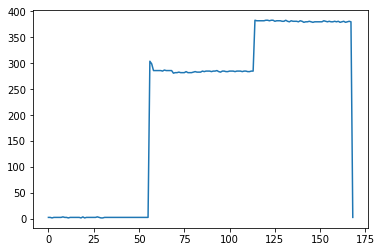

In [29]:
%matplotlib inline
mask = np.ones(len(equip_data[0]['P'].values), dtype=bool)
mask[index] = False
result = equip_data[0]['P'].values[mask]
plt.plot(result)
plt.show()

In [30]:
def peak_remover(arr, threshold):
    '''
    arr : a numpy array that need to remove peaks
    threshold : the threshold to determine what peaks to remove
    '''
    # The following code was adapted from DQ's module
    wf = np.array([0] + list(np.diff(arr)))
    time_s = np.array(range(len(wf)))
    
    pulse_wf = [] # pulse waveform, this is not part of output
    pulse_area = [] # pulse area
    pulse_trig_t = [] # time of first point that is triggered
    pulse_heith_t = [] # height point time
    pulse_end_t = [] # time of last point that is triggered
    pulse_h = [] # pulse height
    
    posi_thresh = threshold 
    nega_thresh = -threshold
    cut_p = (wf > posi_thresh)
    cut_p_diff = np.diff(cut_p*1) # convert boolean to number 
    pp_start_idx = np.where(cut_p_diff == 1)[0] + 1 # first index cutted out by diff - python index (starts with 0)
    pp_end_idx = np.where(cut_p_diff == -1)[0] # we don't need +1 here somehow - python index (starts with 0)

    for i in range(0, min([len(pp_start_idx),len(pp_end_idx)])):
        temp_pulse_wf = wf[np.array(range(pp_start_idx[i],pp_end_idx[i]+1))]
        temp_pulse_time_s = time_s[np.array(range(pp_start_idx[i],pp_end_idx[i]+1))]
        pulse_wf.append(temp_pulse_wf)
        pulse_area.append(temp_pulse_wf.sum())
        pulse_h.append(temp_pulse_wf.max())
        pulse_trig_t.append(temp_pulse_time_s[0])
        cut_pulse_heigh_t = np.where(temp_pulse_wf == temp_pulse_wf.max())
        pulse_heith_t.append(temp_pulse_time_s[cut_pulse_heigh_t[0][0]])
        pulse_end_t.append(temp_pulse_time_s[-1])
        
    cut_n = (wf < nega_thresh)
    cut_n_diff = np.diff(cut_n*1)
    np_start_idx = np.where(cut_n_diff == 1)[0] + 1
    np_end_idx = np.where(cut_n_diff == -1)[0]
    
    for i in range(0, min([len(np_start_idx),len(np_end_idx)])):
        temp_pulse_wf = wf[np.array(range(np_start_idx[i],np_end_idx[i]+1))]
        temp_pulse_time_s = time_s[np.array(range(np_start_idx[i],np_end_idx[i]+1))]
        pulse_wf.append(temp_pulse_wf)
        pulse_area.append(temp_pulse_wf.sum())
        pulse_h.append(temp_pulse_wf.min())
        pulse_trig_t.append(temp_pulse_time_s[0])
        cut_pulse_heigh_t = np.where(temp_pulse_wf == temp_pulse_wf.min())
        pulse_heith_t.append(temp_pulse_time_s[cut_pulse_heigh_t[0][0]])
        pulse_end_t.append(temp_pulse_time_s[-1])
        
    pulse_area = np.array(pulse_area)
    pulse_trig_t = np.array(pulse_trig_t)
    pulse_heith_t = np.array(pulse_heith_t)
    pulse_end_t = np.array(pulse_end_t)
    pulse_h = np.array(pulse_h)
    
    index = np.argsort(pulse_trig_t)
    pulse_area = pulse_area[index]
    pulse_trig_t = pulse_trig_t[index]
    pulse_heith_t = pulse_heith_t[index]
    pulse_end_t = pulse_end_t[index]
    pulse_h = pulse_h[index]
    
    index_raw = [[i-3,i-2,i-1,i,i+1,i+2,i+3] for i in pulse_heith_t]
    #index = np.array([[i-2,i-1,i,i+1,i+2] for i in pulse_heith_t]).flatten()
    index = np.array([[i-1,i,i+1] for i in pulse_heith_t]).flatten()
    mask = np.ones(len(arr), dtype=bool)
    mask[index] = False
    result = arr[mask]
    
    return pulse_area,pulse_trig_t,pulse_heith_t,pulse_end_t,pulse_h, result, mask, index_raw
    #return [pulse_area,pulse_trig_t,pulse_heith_t,pulse_end_t,pulse_h]

In [51]:
def find_ends(mask):
    '''
    mask: a boolean array.
    return the indices of the two ends of a section of False values
    '''
    arr = np.diff(mask)
    index = np.where(np.abs(arr)>0.1)[0]
    pair = []
    for ii in range(int(len(index)/2)):
        pair.append([index[ii*2], index[ii*2+1]+1])
    return pair

def get_pq_trans(equip_data, threshold):
    p_trans=[]
    q_trans=[]
    t_trans=[]
    t_trans_temp=[]
    pq_pair = []
    p_data = equip_data['P'].values
    q_data = equip_data['Q'].values
    pulse_area,pulse_trig_t,pulse_heith_t,pulse_end_t,pulse_h, result_p, mask, index_raw = peak_remover(p_data, threshold)
    pair = find_ends(mask)
    for indices in pair:
        p_trans.append(p_data[indices[1]]-p_data[indices[0]])
        q_trans.append(q_data[indices[1]]-q_data[indices[0]])
        t_trans_temp.append((indices[0]+indices[1])/2)
    # if p_trans and q_trans have zero value at the same location, remove it
    for ii in range(len(p_trans)):
        if abs(p_trans[ii])>1 or abs(q_trans[ii])>1:
            pq_pair.append([p_trans[ii], q_trans[ii]])
            t_trans.append(t_trans_temp[ii])

    return pq_pair,t_trans

In [32]:
wf = np.array([0] + list(np.diff((equip_data[9]['P'].values))))
time_s = np.array(range(len(wf)))

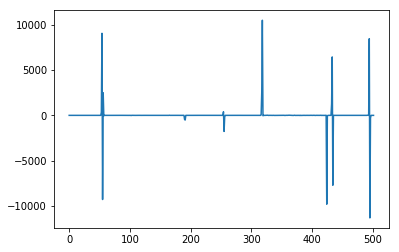

In [33]:
%matplotlib inline
plt.plot(wf)

In [36]:
pair =find_ends(mask)

In [37]:
pair

[[55, 61], [118, 129], [182, 188]]

In [53]:
pq_pair,t_trans = get_pq_trans(equip_data[8])

KeyError: 8

In [40]:
pq_pair

[[139, 193], [20, 13], [-87, -45], [27, 23], [-97, -186]]

In [41]:
t_trans

[59.5, 68.0, 134.0, 139.5, 206.0]

In [42]:
pulse_area,pulse_trig_t,pulse_heith_t,pulse_end_t,pulse_h, result_p, mask, index_raw = peak_remover(equip_data[9]['P'].values, threshold=20)

In [43]:
pulse_heith_t

array([ 54,  55,  56,  57, 191, 254, 255, 318, 319, 424, 433, 434, 494,
       495])

In [44]:
result_q = equip_data[9]['Q'].values[mask]

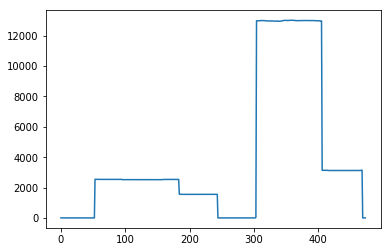

In [45]:
plt.plot(result_p)
plt.show()

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
train = trans_df.iloc[:,0:2].values
label = trans_df.iloc[:,2].values
knn.fit(train,label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [47]:
predic = knn.predict(np.array(pq_pair))

In [49]:
for ii in predic:
    print (ii)

yd9:关闭 to yd9:除湿
yd8:关闭 to yd8:保温
yd9:制冷 to yd9:除湿
yd6:关闭 to yd6:打开
yd9:辅热 to yd9:关闭


In [50]:
path = u"../A题"
unknown3=pd.ExcelFile(path+ u"全部数据/附件4/设备组3.xlsx")
equip_data=unknown3.parse(u'设备数据')
pq_pair,t_trans= get_pq_trans(equip_data)
pq_pair,t_trans

TypeError: get_pq_trans() missing 1 required positional argument: 'threshold'

In [ ]:
pulse_area,pulse_trig_t,pulse_heith_t,pulse_end_t,pulse_h, result_p, mask, index_raw = peak_remover(equip_data['P'].values, threshold=20)

In [ ]:
plt.plot(equip_data['P'].values)
plt.show()

In [ ]:
plt.plot(equip_data['P'].values)
plt.show()

In [ ]:
predic = knn.predict(np.array(pq_pair))
for ii,element in enumerate(predic):
    print element, t_trans[ii]

In [ ]:
path = u"C:/Users/Administrator/git/NILM/A题"
unknown5=pd.ExcelFile(path+ u"全部数据/附件3（不含操作记录）/设备组5-YD3+YD5+YD11.xlsx")
equip_data=unknown5.parse(u'设备数据')
pq_pair,t_trans= get_pq_trans(equip_data, threshold=200) # Here we have to change the threshold to 200 in order to get rid of the fluctuations
pq_pair,t_trans

In [ ]:
pulse_area,pulse_trig_t,pulse_heith_t,pulse_end_t,pulse_h, result_p, mask, index_raw = peak_remover(equip_data['P'].values, threshold=200)
plt.figure()
plt.plot(equip_data['P'].values)
plt.show()
plt.figure()
plt.plot(equip_data['P'].values)
plt.show()

In [60]:
predic = knn.predict(np.array(pq_pair))
for ii,element in enumerate(predic):
    print (element, t_trans[ii])

yd9:关闭 to yd9:除湿 59.5
yd8:关闭 to yd8:保温 68.0
yd9:制冷 to yd9:除湿 134.0
yd6:关闭 to yd6:打开 139.5
yd9:辅热 to yd9:关闭 206.0
